In [1]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [2]:
#  GE83
# This code block imports the necessary libraries to complete analysis.

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import dmba

%matplotlib inline

In [70]:
# GE83
# This code block loads the data into the notebook.

import pandas as pd

hurricanes_df = pd.read_csv('hurricanes7.csv')

In [4]:
# GE83
# This code block identifies and selects numeric columns for conversion to float and
# displays the first few rows to verify the changes.

hurricanes_df.set_index('NextWindHigher', inplace=True)
numeric_columns = hurricanes_df.select_dtypes(include=['number'])

hurricanes_df[numeric_columns.columns] = numeric_columns.astype('float64')

hurricanes_df.head()

,ATCF,Name,RecordNum,MaxWind,MinPressure,NextWind,Elevation,DeepOcean,Speed,Size34,Size50,Size64,WindInc,PressureInc,Size34Inc,Size50Inc,Size64Inc,ElevationInc,SpeedInc
NextWindHigher,,,,,,,,,,,,,,,,,,,
1,AL072008,GUSTAV,1.0,25.0,1008.0,30.0,-5050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AL072008,GUSTAV,2.0,30.0,1005.0,35.0,-4786.0,1.0,13.0,0.0,0.0,0.0,5.0,-3.0,0.0,0.0,0.0,264.0,13.0
1,AL072008,GUSTAV,3.0,35.0,1002.0,50.0,-3922.0,1.0,12.0,60.0,0.0,0.0,5.0,-3.0,60.0,0.0,0.0,864.0,-1.0
1,AL072008,GUSTAV,4.0,50.0,996.0,60.0,-3826.0,1.0,11.0,75.0,20.0,0.0,15.0,-6.0,15.0,20.0,0.0,96.0,-1.0
1,AL072008,GUSTAV,5.0,60.0,991.0,75.0,-3900.0,1.0,9.0,75.0,20.0,0.0,10.0,-5.0,0.0,0.0,0.0,-74.0,-2.0


In [5]:
# GE83
# This code block computes the Euclidean distance matrix.

import pandas as pd
from sklearn.metrics import pairwise_distances

d = pairwise_distances(numeric_columns, metric='euclidean')

distance_df = pd.DataFrame(d, columns=numeric_columns.index, index=numeric_columns.index)
distance_df.head(5)

NextWindHigher,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NextWindHigher,,,,,,,,,,,,,,,,,,,,,
1,0.000000,373.930475,1423.656911,1231.301344,1156.618347,2767.115285,1913.129635,5808.061639,5224.197546,4177.688835,...,9239.992587,9065.084997,9243.498905,9259.507222,9232.570769,9232.963284,9231.598778,9259.444908,9360.905298,9735.871866
1,373.930475,0.000000,1055.534462,978.720083,953.016264,2413.036054,2098.844682,5435.976453,4930.060852,4010.356094,...,9092.272048,8943.974620,9095.393779,9118.674026,9094.969434,9093.989169,9092.963763,9118.296003,9212.036908,9564.392244
1,1423.656911,1055.534462,0.000000,776.248671,941.258200,1386.290013,2704.926247,4389.979841,4043.283938,3522.782281,...,8682.225751,8606.007379,8684.100932,8724.908194,8711.795682,8706.187685,8706.075752,8728.169739,8796.465256,9079.343148
1,1231.301344,978.720083,776.248671,0.000000,188.103695,1709.284646,1978.799636,4867.957375,3999.628358,3058.134235,...,8622.339358,8490.573067,8626.150532,8640.842725,8620.836618,8619.605211,8618.847197,8644.305351,8724.837019,9039.505296
1,1156.618347,953.016264,941.258200,188.103695,0.000000,1882.285579,1794.473460,5044.995144,4103.326455,3061.603175,...,8660.390927,8513.395327,8664.587007,8673.872146,8651.478891,8651.739074,8650.805165,8677.122680,8762.106482,9088.407616


In [71]:
print(hurricanes_df.columns)

Index(['ATCF', 'Name', 'RecordNum', 'MaxWind', 'MinPressure', 'NextWind',
       'NextWindHigher', 'Elevation', 'DeepOcean', 'Speed', 'Size34', 'Size50',
       'Size64', 'WindInc', 'PressureInc', 'Size34Inc', 'Size50Inc',
       'Size64Inc', 'ElevationInc', 'SpeedInc'],
      dtype='object')


In [31]:
# GE83
# This code block uses pandas to normalize the input variables by using the sample SD.
# The block will then compute the normalized distance based on NextWindHigher and Speed.

import pandas as pd
from sklearn.metrics import pairwise_distances

# pandas using sample SD for'NextWindHigher' and 'Speed'
hurricanes_df_norm = (hurricanes_df[['NextWindHigher', 'Speed']] - hurricanes_df[['NextWindHigher', 'Speed']].mean()) / hurricanes_df[['NextWindHigher', 'Speed']].std()

d_norm = pairwise_distances(hurricanes_df_norm, metric='euclidean')

distance_df = pd.DataFrame(d_norm, columns=hurricanes_df.index, index=hurricanes_df.index)

print(distance_df.head(5))

       0         1         2         3         4         5         6     \
0  0.000000  1.682051  1.552663  1.423274  1.164497  0.776331  2.459820   
1  1.682051  0.000000  0.129389  0.258777  0.517554  0.905720  2.415176   
2  1.552663  0.129389  0.000000  0.129389  0.388166  0.776331  2.376745   
3  1.423274  0.258777  0.129389  0.000000  0.258777  0.646943  2.344834   
4  1.164497  0.517554  0.388166  0.258777  0.000000  0.388166  2.301597   

       7         8         9     ...      7716      7717      7718      7719  \
0  2.510345  2.344834  2.319710  ...  2.764262  2.838958  3.264138  3.173113   
1  2.376745  2.566406  2.627646  ...  2.290660  2.287003  2.376745  2.344834   
2  2.344834  2.510345  2.566406  ...  2.287003  2.290660  2.415176  2.376745   
3  2.319710  2.459820  2.510345  ...  2.290660  2.301597  2.459820  2.415176   
4  2.290660  2.376745  2.415176  ...  2.319710  2.344834  2.566406  2.510345   

       7720      7721      7722      7723      7724      7725  
0  2

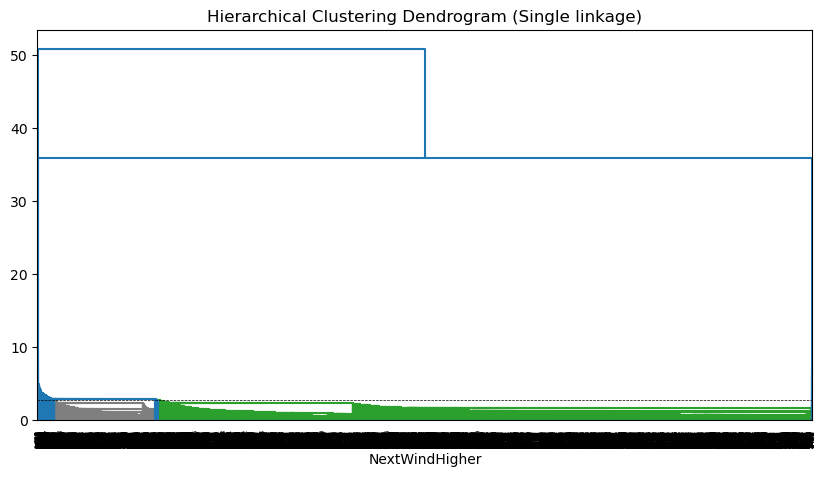

In [3]:
# GE83
# This code block performs hierarchial clustering and prints the results in a dendogram.

import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

numeric_columns = hurricanes_df.select_dtypes(include=['number'])

scaler = StandardScaler()
hurricanes_df_norm = scaler.fit_transform(numeric_columns)

Z = linkage(hurricanes_df_norm, method='single')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('NextWindHigher')
dendrogram(Z, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

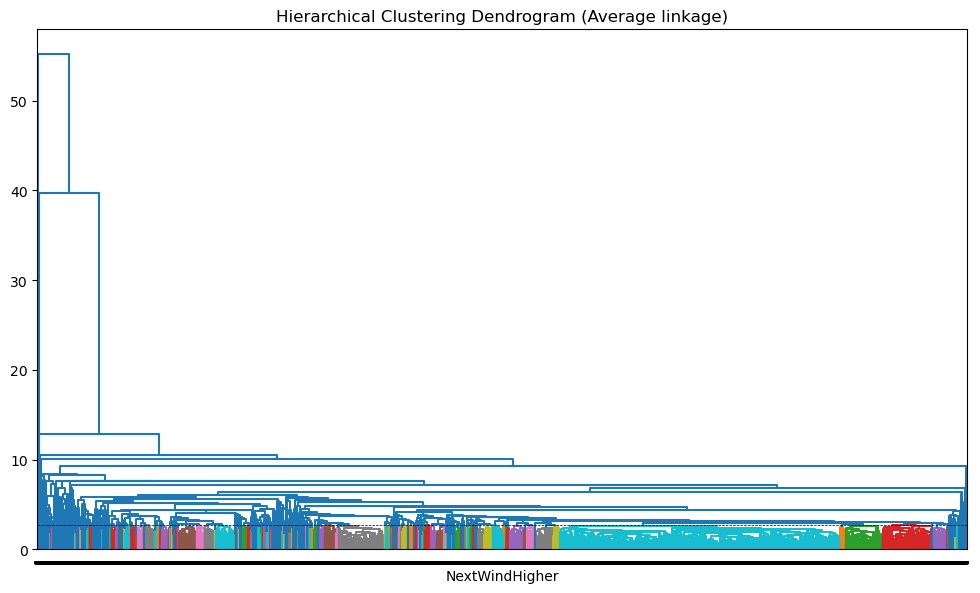

In [48]:
# GE83
# This code block creates a dendrogram using the average linkage.

import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

numeric_columns = hurricanes_df.select_dtypes(include=['number'])

numeric_columns_subset = numeric_columns.iloc[:10, :]

scaler = StandardScaler()
hurricanes_df_norm = scaler.fit_transform(numeric_columns)

Z = linkage(hurricanes_df_norm, method='average')

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Average linkage)')
plt.xlabel('NextWindHigher')

data_point_labels = hurricanes_df.index.tolist()
dendrogram(Z, labels=data_point_labels, color_threshold=2.75) 
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [55]:
# GE83
# This code block creates k-means clustering on the data and creating a visualization of the data
# points assigned to each cluster.

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_columns = hurricanes_df.select_dtypes(include=['number'])
numeric_columns = numeric_columns.apply(lambda x: x.astype('float64'))
hurricanes_df_norm = scaler.fit_transform(numeric_columns)

kmeans = KMeans(n_clusters=2, random_state=0).fit(hurricanes_df_norm)

hurricanes_df['Cluster'] = kmeans.labels_

for cluster_num, cluster_data in hurricanes_df.groupby('Cluster'):
    cluster_num_str = str(cluster_num)
    print(f'Cluster {cluster_num_str}:')
    print(', '.join(map(str, cluster_data.index)))
    print()

Cluster 0:
1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [64]:
# GE83
# This code block creates k-means clustering and creates centroids of the clusters.

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hurricanes_df_norm = scaler.fit_transform(hurricanes_df_norm)

kmeans = KMeans(n_clusters=2, random_state=0).fit(hurricanes_df_norm)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=hurricanes_df.columns[:-1])

pd.set_option('display.precision', 3)
print(centroids)
pd.reset_option('display.precision')

        ATCF  RecordNum  MaxWind  MinPressure  NextWind  Elevation  DeepOcean  \
0  1.927e-04     -0.468    0.477       -0.450     0.051     -0.051     -0.104   
1 -5.498e-04      1.336   -1.360        1.285    -0.145      0.145      0.297   

   Speed  Size34  Size50  Size64  WindInc  PressureInc  Size34Inc  Size50Inc  \
0 -0.334  -0.360  -0.209  -0.058    0.103       -0.056     -0.047     -0.034   
1  0.954   1.027   0.596   0.164   -0.293        0.161      0.135      0.098   

   Size64Inc  ElevationInc  SpeedInc  
0     -0.016         0.014    -0.592  
1      0.046        -0.041     1.689  


C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [58]:
# GE83
# This code block calculates the within cluster sum of squares for the two clusters.

withinClusterSS = [0] * 2
clusterCount = [0] * 2
for cluster, distance in zip(kmeans.labels_, kmeans.transform(hurricanes_df_norm)):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1
for cluster, withClustSS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster, 
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (5721 members): 68748.50 within cluster
Cluster 1 (2005 members): 41182.73 within cluster


In [38]:
# GE83
# This code block calculates the data points to cluster centers and calculates the squared
# distance of each data point to its cluster.

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_columns = hurricanes_df.select_dtypes(include=['number'])
numeric_columns = numeric_columns.apply(lambda x: x.astype('float64'))
hurricanes_df_norm = scaler.fit_transform(numeric_columns)

kmeans = KMeans(n_clusters=2, random_state=0).fit(hurricanes_df_norm)

distances = kmeans.transform(hurricanes_df_norm)

minSquaredDistances = (distances.min(axis=1) ** 2)

df = pd.DataFrame({'squaredDistance': minSquaredDistances, 'cluster': kmeans.labels_}, 
    index=hurricanes_df.index) 

for cluster, data in df.groupby('cluster'):
    count = len(data)
    withinClustSS = data.squaredDistance.sum()
    print(f'Cluster {cluster} ({count} members): {withinClustSS:.2f} within cluster')

Cluster 0 (5721 members): 68748.50 within cluster
Cluster 1 (2005 members): 41182.73 within cluster


C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [63]:
# GE83
# This code block normalizes the data and assigns the data to cluster labels,
# then calculates and prints the mean values for each cluster.

scaler = StandardScaler()
hurricanes_df_norm = scaler.fit_transform(hurricanes_df_norm)

num_clusters = 2

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(hurricanes_df_norm)

cluster_labels = pd.Series(kmeans.labels_, name='Cluster')

data_with_clusters = pd.concat([pd.DataFrame(hurricanes_df_norm), cluster_labels], axis=1)

cluster_means = data_with_clusters.groupby('Cluster').mean()

print(cluster_means)

                0         1         2         3         4         5         6  \
Cluster                                                                         
0        0.000193 -0.468378  0.476743 -0.450184  0.050964 -0.050656 -0.104212   
1       -0.000550  1.336453 -1.360323  1.284539 -0.145419  0.144542  0.297354   

                7         8         9        10        11        12        13  \
Cluster                                                                         
0       -0.334248 -0.360040 -0.208886 -0.057640  0.102545 -0.056321 -0.047176   
1        0.953732  1.027325  0.596028  0.164468 -0.292599  0.160704  0.134612   

               14        15        16        17  
Cluster                                          
0       -0.034459 -0.016281  0.014263 -0.591999  
1        0.098323  0.046456 -0.040697  1.689191  


C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [59]:
# GE83
# This code block correctly calculates and prints the pairwise
# Euclidean distances.

import pandas as pd
from sklearn.metrics import pairwise_distances

cluster_distances = pairwise_distances(kmeans.cluster_centers_, metric='euclidean')

distance_df = pd.DataFrame(cluster_distances, columns=[f'Cluster {i}' for i in range(len(cluster_distances))], index=[f'Cluster {i}' for i in range(len(cluster_distances))])

print(distance_df)

           Cluster 0  Cluster 1
Cluster 0   0.000000   4.430012
Cluster 1   4.430012   0.000000


In [60]:
# GE83
# This code block calculates the SUM of the pairwise Euclidean distance.

import pandas as pd
from sklearn.metrics import pairwise_distances

cluster_distances = pairwise_distances(kmeans.cluster_centers_, metric='euclidean')

distance_df = pd.DataFrame(cluster_distances, columns=[f'Cluster {i}' for i in range(len(cluster_distances))], index=[f'Cluster {i}' for i in range(len(cluster_distances))])

sum_of_distances = distance_df.sum(axis=0)

print(sum_of_distances)

Cluster 0    4.430012
Cluster 1    4.430012
dtype: float64


C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of

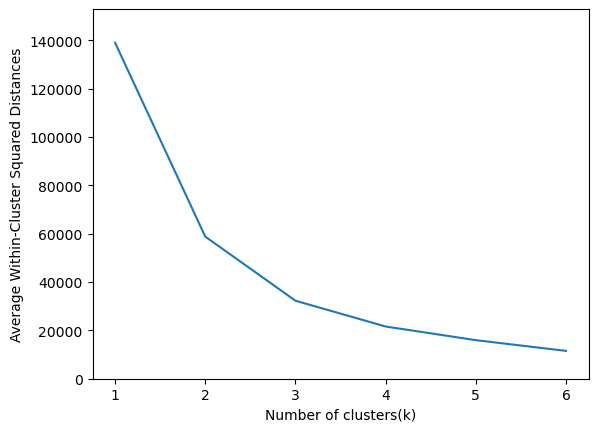

In [25]:
# GE83
# This code block 

inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(hurricanes_df_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

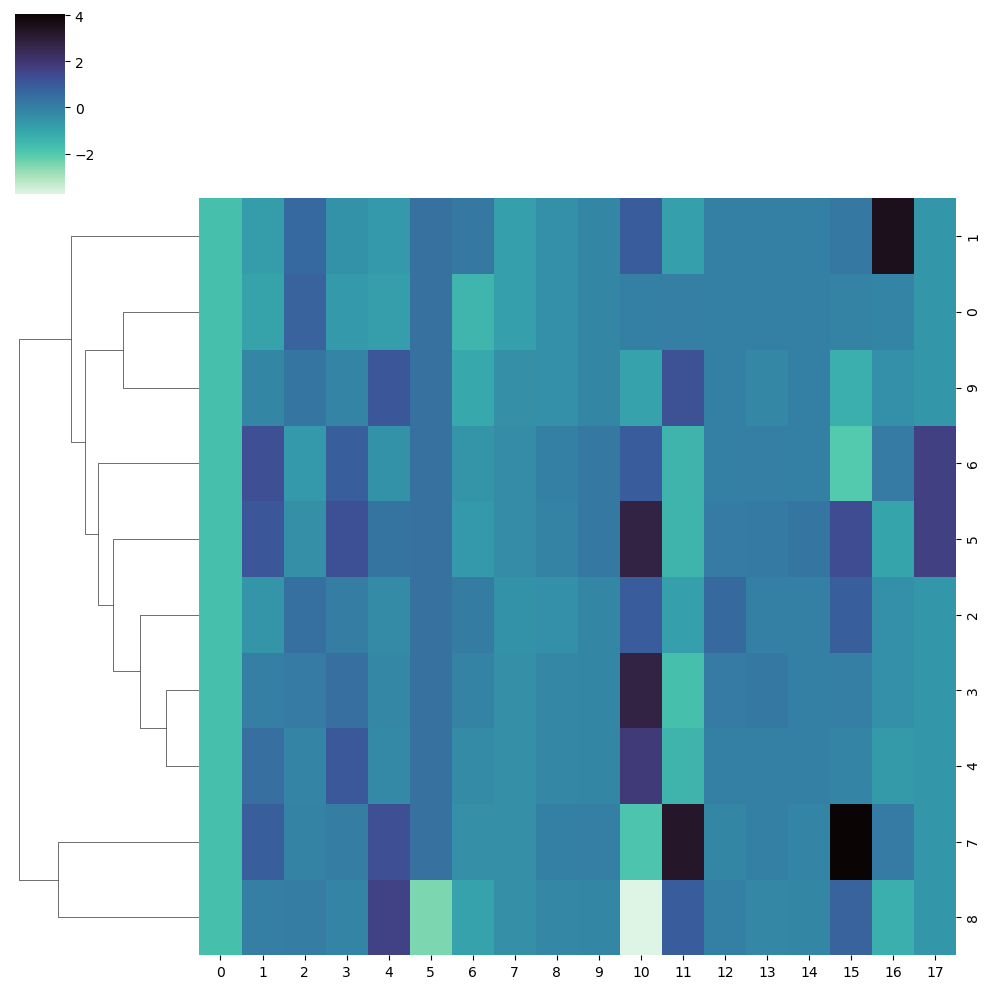

In [61]:
# GE83
# This code block shows the first 10 entries of a cluster heatmap of the data.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

subset_hurricanes_df_norm = hurricanes_df_norm[:10, :]

sns.clustermap(subset_hurricanes_df_norm, method='average', col_cluster=False, cmap='mako_r')

plt.show()

C:\Users\GXE6000\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


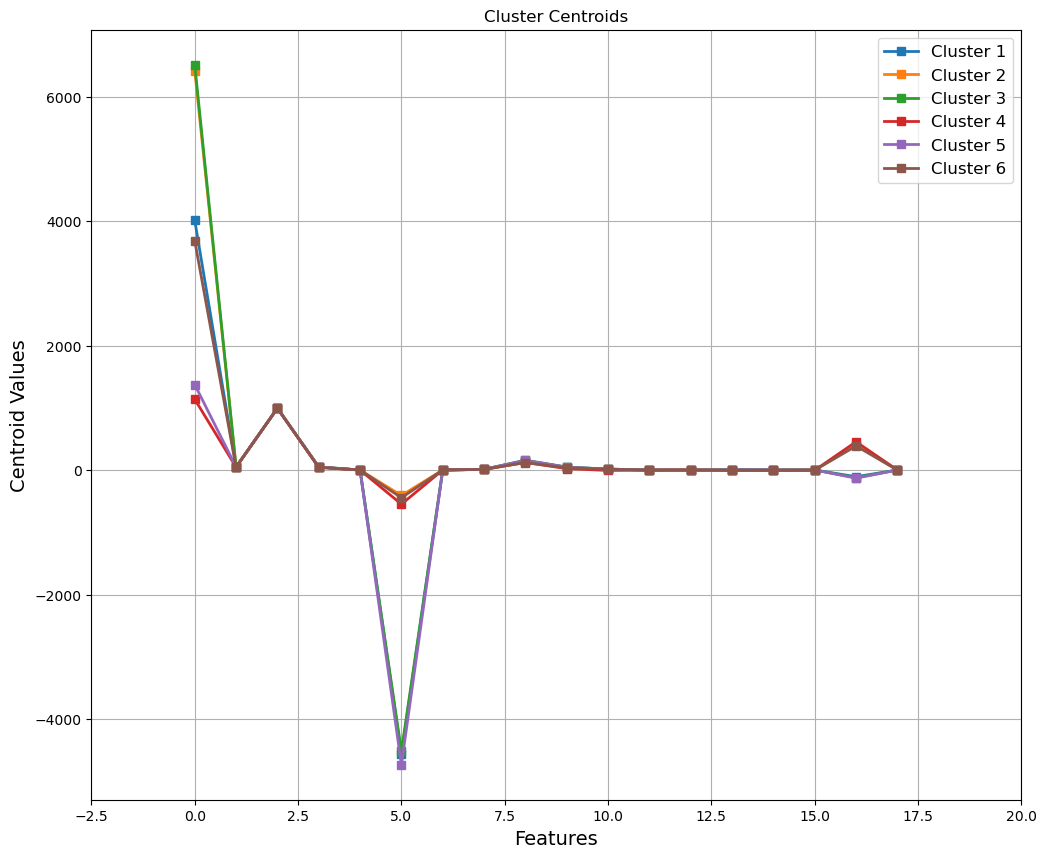

In [103]:
# GE83
# This code block loads the data, checks for data types in columns to correctly
# produce code, fit the k-means clustering, collects the cluster centroids, and
# creates a line chart for 6 clusters.

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

your_data = pd.read_csv('hurricanes7.csv')
non_numeric_columns = your_data.select_dtypes(exclude=['number']).columns
your_data_numeric = your_data.drop(columns=non_numeric_columns)

kmeans = KMeans(n_clusters=6, random_state=0).fit(your_data_numeric)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(12, 10))

for i in range(len(centroids)):
    plt.plot(centroids[i], label=f'Cluster {i + 1}', marker='s', linewidth=2)

plt.xlabel('Features', fontsize=14)
plt.ylabel('Centroid Values', fontsize=14)
plt.title('Cluster Centroids', fontsize=12)
plt.xlim(-2.5,20)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()